In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

In [2]:
import tensorflow as tf
import keras
import keras.backend as K

from keras.models import Model
from keras.layers import Dense, Input
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU


np.random.seed(123)

Using TensorFlow backend.


In [3]:
noise_size = 2
n_samples = 1000000

#z = np.random.uniform(0, 1, (n_samples, noise_size))
z = np.random.normal(0.1, 0.1, (n_samples, noise_size))
X_true = np.random.normal(0.5, 0.15, (n_samples, 2))

#z_test = np.random.uniform(0, 1, (n_samples//100, noise_size))
z_test = np.random.normal(0.1, 0.1, (n_samples//100, noise_size))
X_true_test = np.random.normal(0.5, 0.15, (n_samples//100, 2))

In [4]:
# Generator
XXX = """
g_in = Input(shape=(noise_size,))
g = Dense(12, activation=LeakyReLU())(g_in)
g = Dense(12, activation=LeakyReLU())(g)
g = Dense(12, activation=LeakyReLU())(g)
g = Dense(2, activation='tanh')(g)
"""

g_in = Input(shape=(noise_size,))
g = Dense(12, activation='tanh')(g_in)
g = Dense(12, activation='tanh')(g)
#g = Dense(12, activation='tanh')(g) #not needed for gaussian to gaussian
g = Dense(2, activation='linear')(g)

G = Model(inputs=g_in, outputs=g)
G.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy')

# Discriminator
XXX = """
d_in = Input(shape=(2,))
d = Dense(12, activation=LeakyReLU())(d_in)
d = Dense(12, activation=LeakyReLU())(d)
d = Dense(12, activation=LeakyReLU())(d)
d = Dense(12, activation=LeakyReLU())(d)
d = Dense(12, activation=LeakyReLU())(d)
d = Dense(1, activation='sigmoid')(d)
"""
d_in = Input(shape=(2,))
d = Dense(12, activation='tanh')(d_in)
d = Dense(12, activation='tanh')(d)
d = Dense(12, activation='tanh')(d)
d = Dense(12, activation='tanh')(d)
d = Dense(1, activation='sigmoid')(d)

D = Model(inputs=d_in, outputs=d)
D.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')


# noise -> generator -> discriminator
noise = Input(shape=(noise_size,))
fake = G(noise)
D.trainable = False
GD_ = D(fake)
GD = Model(noise, GD_)
GD.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy')

In [5]:
XXX = """
# train only D
X_gen = G.predict(z)

# training data for the discriminator
X = np.vstack([X_gen, X_true])
y = np.vstack([np.zeros(n_samples).reshape(-1, 1), # zero for fakes
               np.ones(n_samples).reshape(-1, 1)]) # one for true samples

train_loss = D.fit(X, y, epochs=1, batch_size=500, verbose=1)
"""

In [6]:
train_losses = {'D': [], 'GD': []}
test_losses = {'D': [], 'GD': []}

In [7]:
n_batch = 32

#for i_batch in range(3 * (n_samples//n_batch)):
for i_batch in range(25000): # 25000 iterations for norm to gaus
    if not i_batch%1000:
        print(i_batch)

    # pick examples for this batch
    idx = np.random.randint(0, 1000000, n_batch)
    X_true_ = X_true[idx]
    z_ = z[idx]

    # training data for the discriminator
    X_gen_ = G.predict(z_)
    X_ = np.vstack([X_gen_, X_true_])
    y_ = np.vstack([np.zeros(n_batch).reshape(-1, 1), # zero for fakes
                    0.999*np.ones(n_batch).reshape(-1, 1)]) # one for true samples

    train_loss = D.train_on_batch(X_, y_)
    train_losses['D'].append(train_loss)

    idx = np.random.randint(0, 1000000, 2 * n_batch)
    z_ = z[idx]
    train_loss = GD.train_on_batch(z_, np.ones(2* n_batch).reshape(-1, 1))
    train_losses['GD'].append(train_loss)



    XXX="""
    # testing data
    X_gen = G.predict(z_test)
    X = np.vstack([X_gen, X_true_test])
    y = np.vstack([np.zeros(n_samples//100).reshape(-1, 1),
                   np.ones(n_samples//100).reshape(-1, 1)])
    
    test_loss = GD.evaluate(z_test, np.ones(n_samples//100), verbose=0)
    test_losses['GD'].append(test_loss)
    
    test_loss = D.evaluate(X, y, verbose=0)
    test_losses['D'].append(test_loss)
    """

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


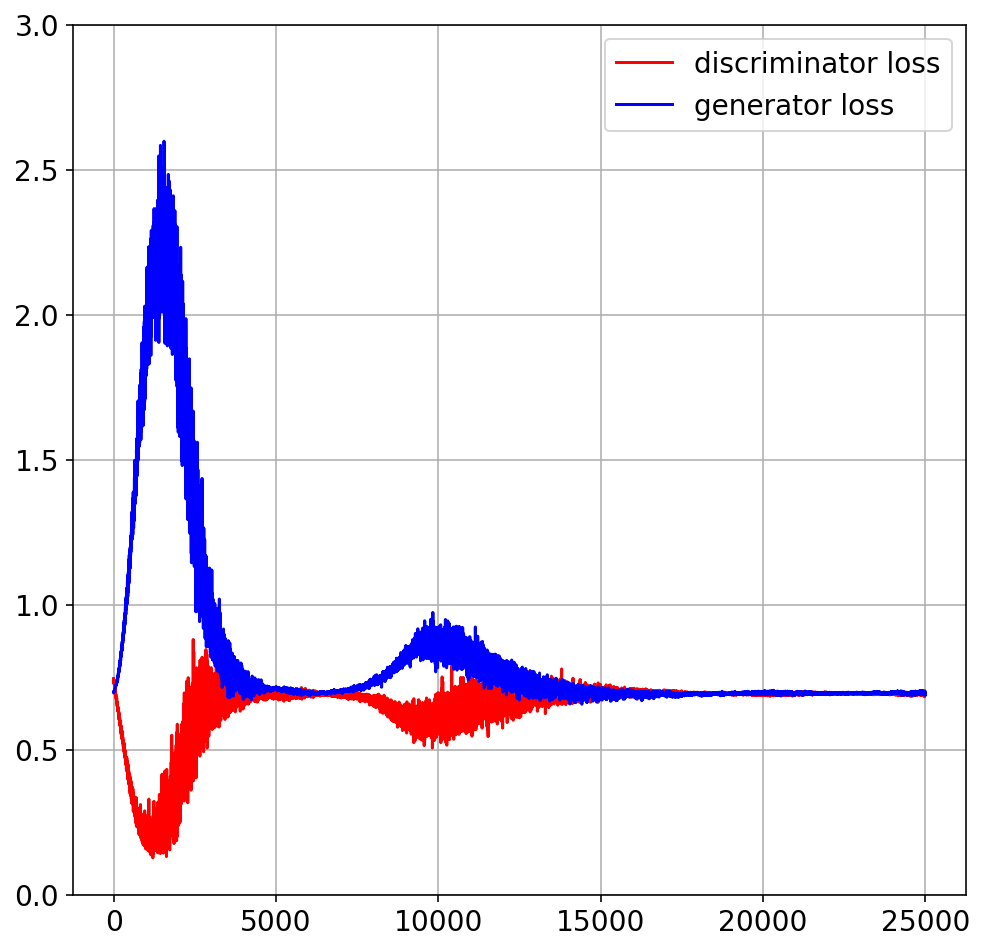

In [8]:
plt.plot(train_losses['D'], 'r-', label='discriminator loss')
plt.plot(train_losses['GD'], 'b-', label='generator loss');
plt.ylim([0,3])
plt.grid()
plt.legend(loc='best');

0.485027 0.847627


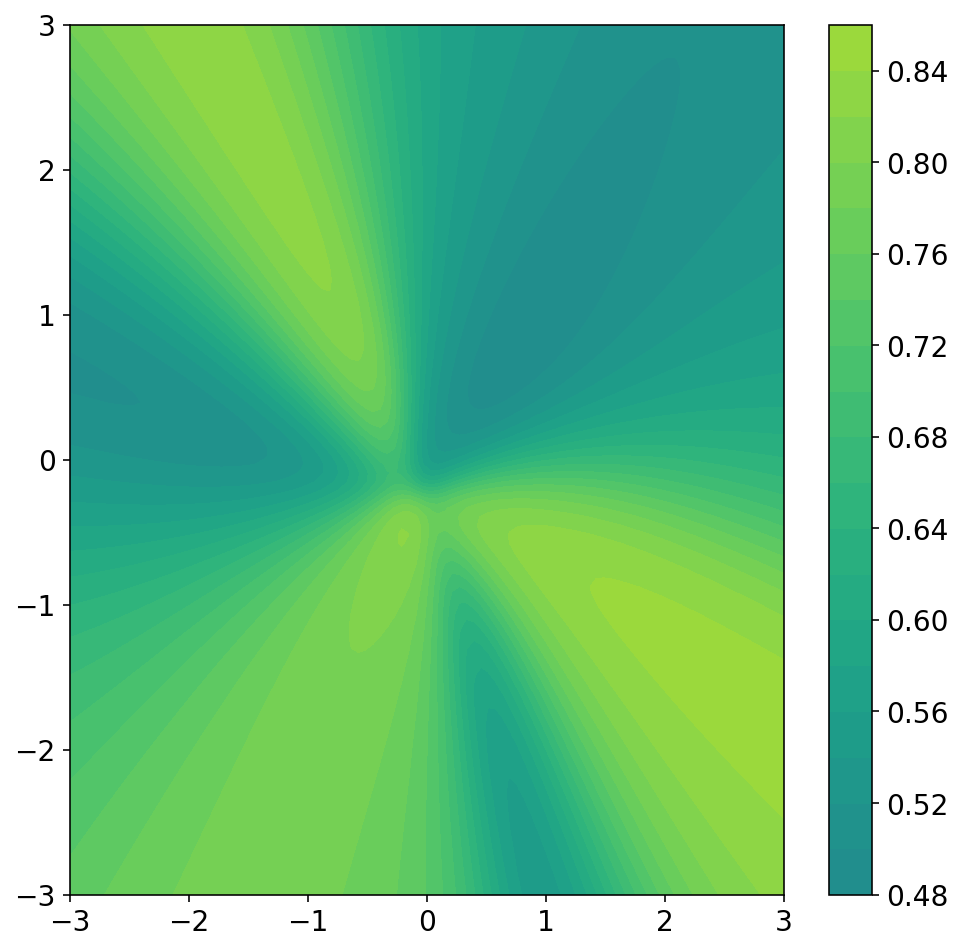

In [9]:
n_steps = 100
xx, yy = np.meshgrid(np.linspace(-3, 3, n_steps),
                     np.linspace(-3, 3, n_steps))
#xx, yy = np.meshgrid(np.linspace(-0.1, 1.1, n_steps),
#                     np.linspace(-0.1, 1.1, n_steps))

zz = D.predict(np.c_[xx.ravel(), yy.ravel()])

print(zz.min(), zz.max())
zz = zz.reshape(xx.shape)
plt.contourf(xx, yy, zz, 20, cmap=plt.cm.viridis, vmin=0, vmax=1)
plt.colorbar();

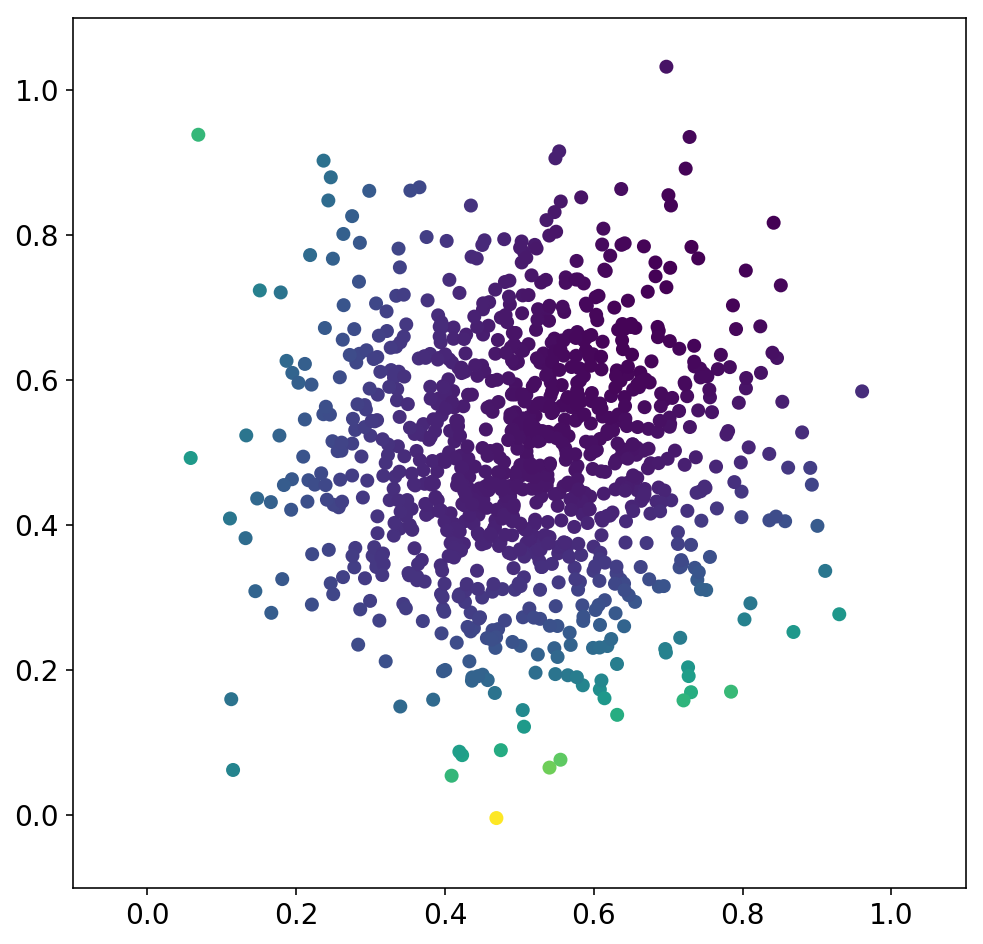

In [10]:
idx = np.random.randint(0, 1000000, 1000)

y_pred = D.predict(X_true[idx])

plt.scatter(X_true[idx,0], X_true[idx,1], c=y_pred);
plt.xlim([-0.1,1.1]);
plt.ylim([-0.1,1.1]);

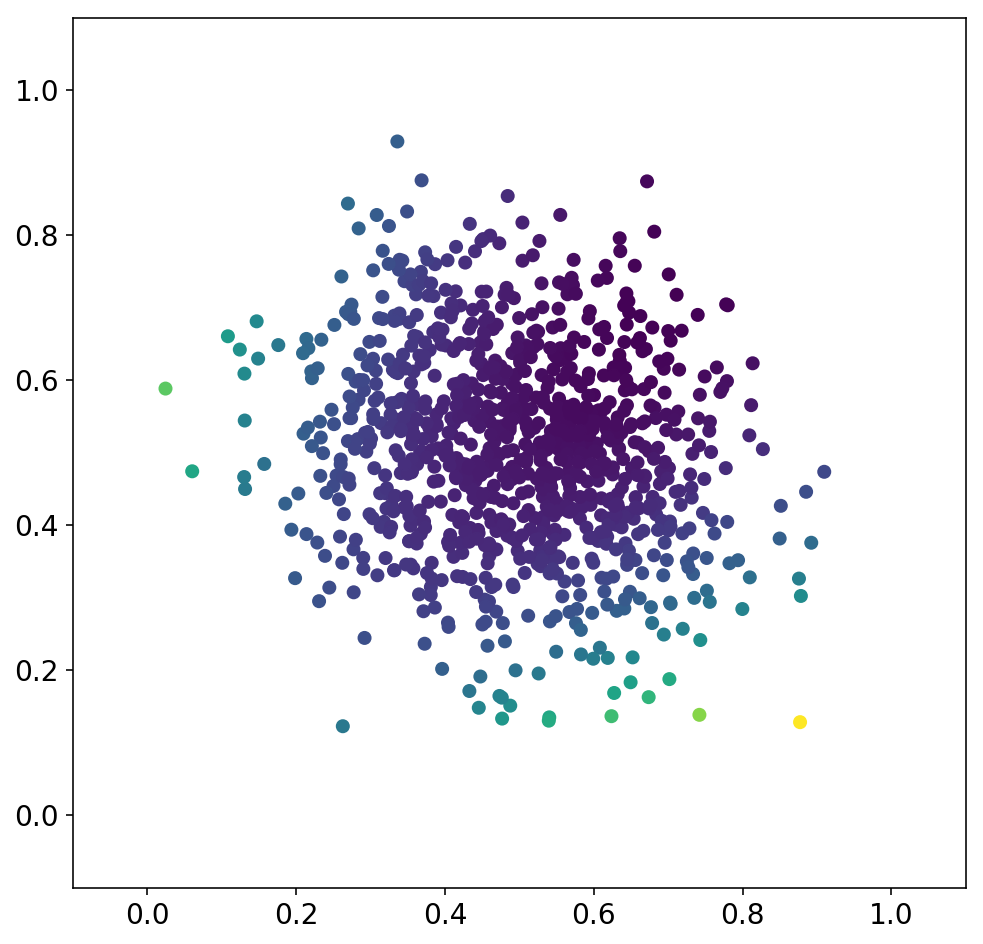

In [11]:
idx = np.random.randint(0, 1000000, 1000)
X_gen = G.predict(z[idx])
y_pred = D.predict(X_gen)

plt.scatter(X_gen[:,0], X_gen[:,1], c=y_pred);
plt.xlim([-0.1,1.1]);
plt.ylim([-0.1,1.1]);

## Testing data

What about unseen data?

In [12]:
D.predict(G.predict(z_test))

array([[ 0.52366024],
       [ 0.50865537],
       [ 0.50113577],
       ..., 
       [ 0.48837885],
       [ 0.49348339],
       [ 0.49091372]], dtype=float32)

In [13]:
D.predict(X_true_test)

array([[ 0.50380278],
       [ 0.52636534],
       [ 0.49443313],
       ..., 
       [ 0.5065704 ],
       [ 0.49635723],
       [ 0.51420093]], dtype=float32)

In [14]:
# testing data
XXX = """
X_gen = G.predict(z_test)
X = np.vstack([X_gen, X_true_test])
y = np.vstack([np.zeros(n_samples//100).reshape(-1, 1),
               np.ones(n_samples//100).reshape(-1, 1)])

test_loss = GD.evaluate(z_test, np.ones(n_samples//100), verbose=0)
test_losses['GD'].append(test_loss)

test_loss = D.evaluate(X, y, verbose=0)
test_losses['D'].append(test_loss)
"""